In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from glob import glob

/home/davidstewart/penv-ML/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/davidstewart/penv-ML/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [73]:
df = pd.read_parquet('Xsec_groups/df_Xsec_0.parquet')
print(df[df['IP_eta']>-10.00].shape[0])
# print(np.size(df['IP_eta']>5.==True))

2648256


Matching and eta cuts, N events = 2232039.0, Xsec mean = 5.6e-09


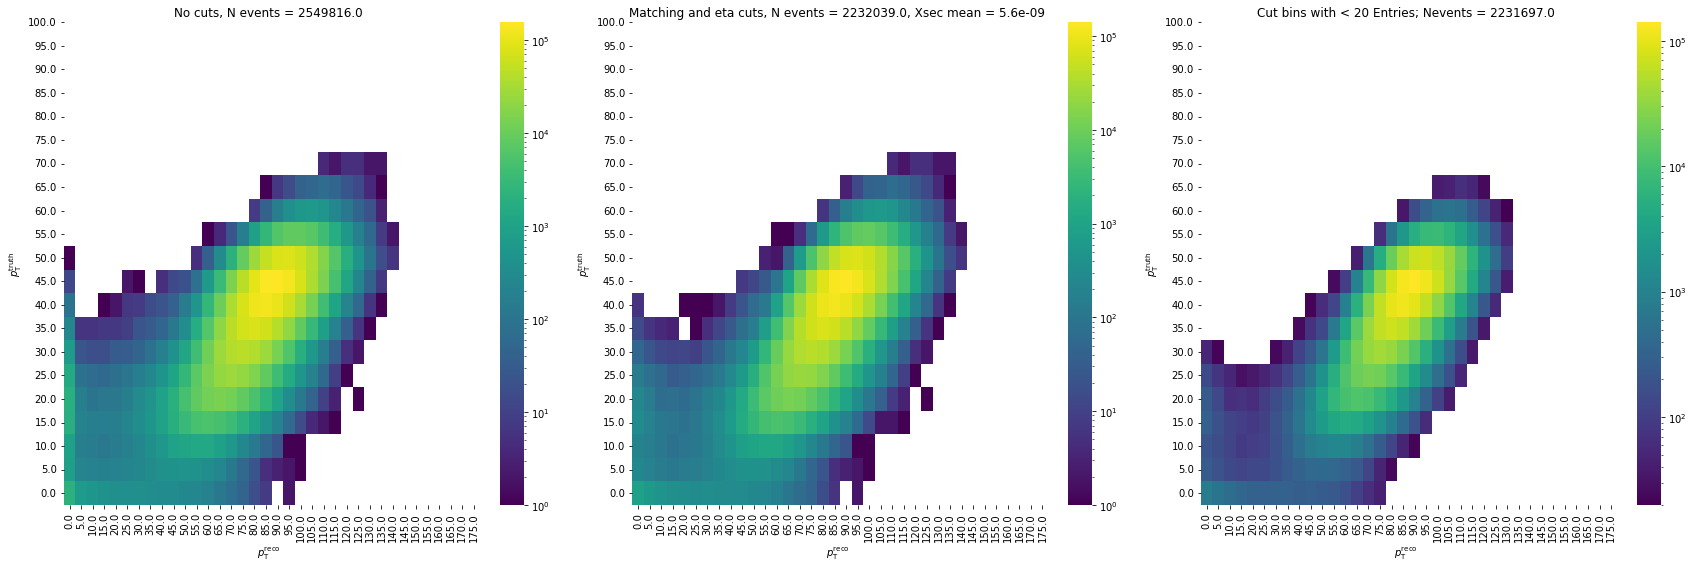

Matching and eta cuts, N events = 1772457.0, Xsec mean = 2.2e-06


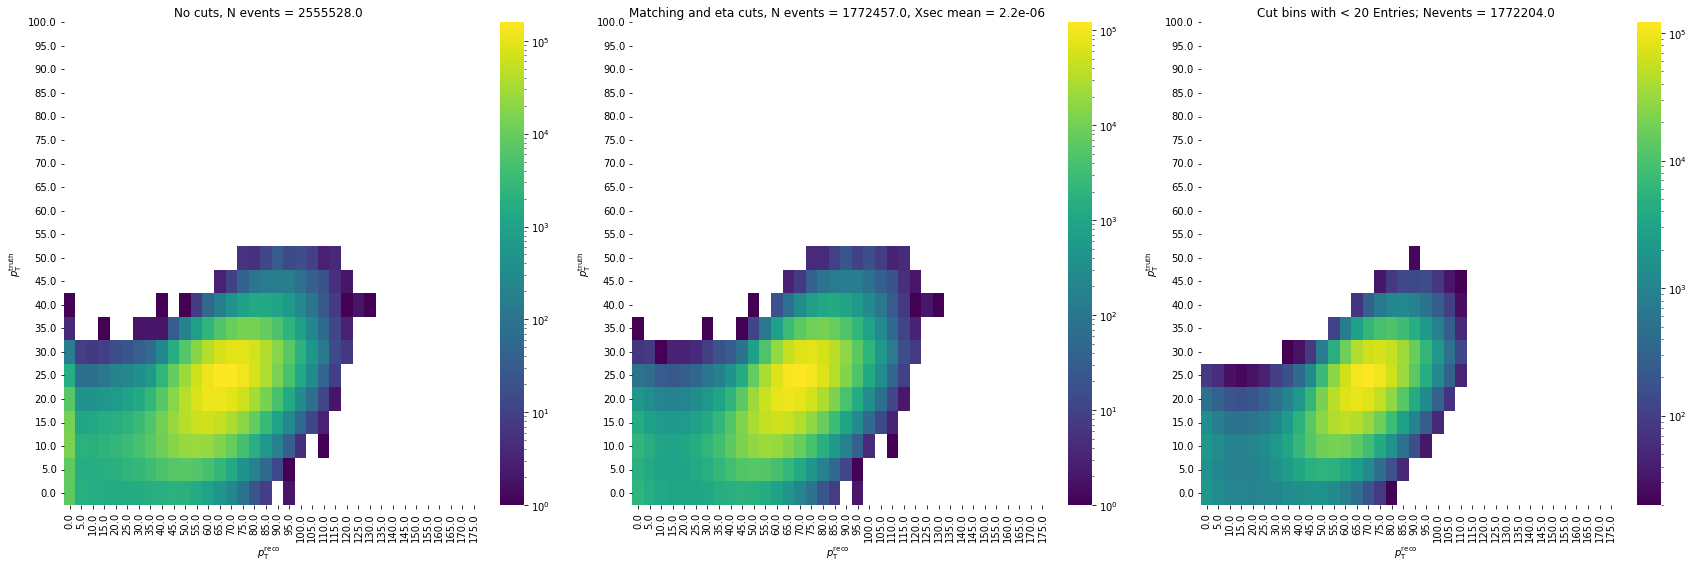

Matching and eta cuts, N events = 1873682.0, Xsec mean = 6.4e-07


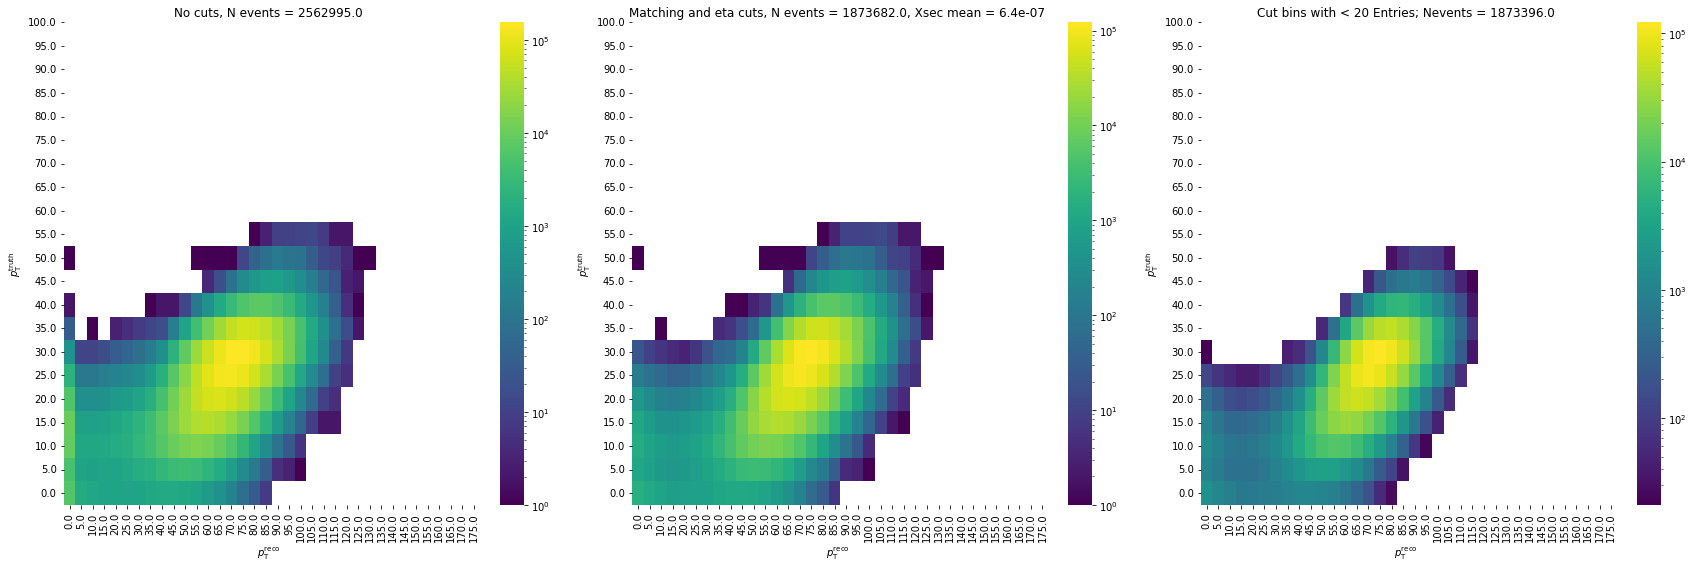

Matching and eta cuts, N events = 1663366.0, Xsec mean = 7.6e-06


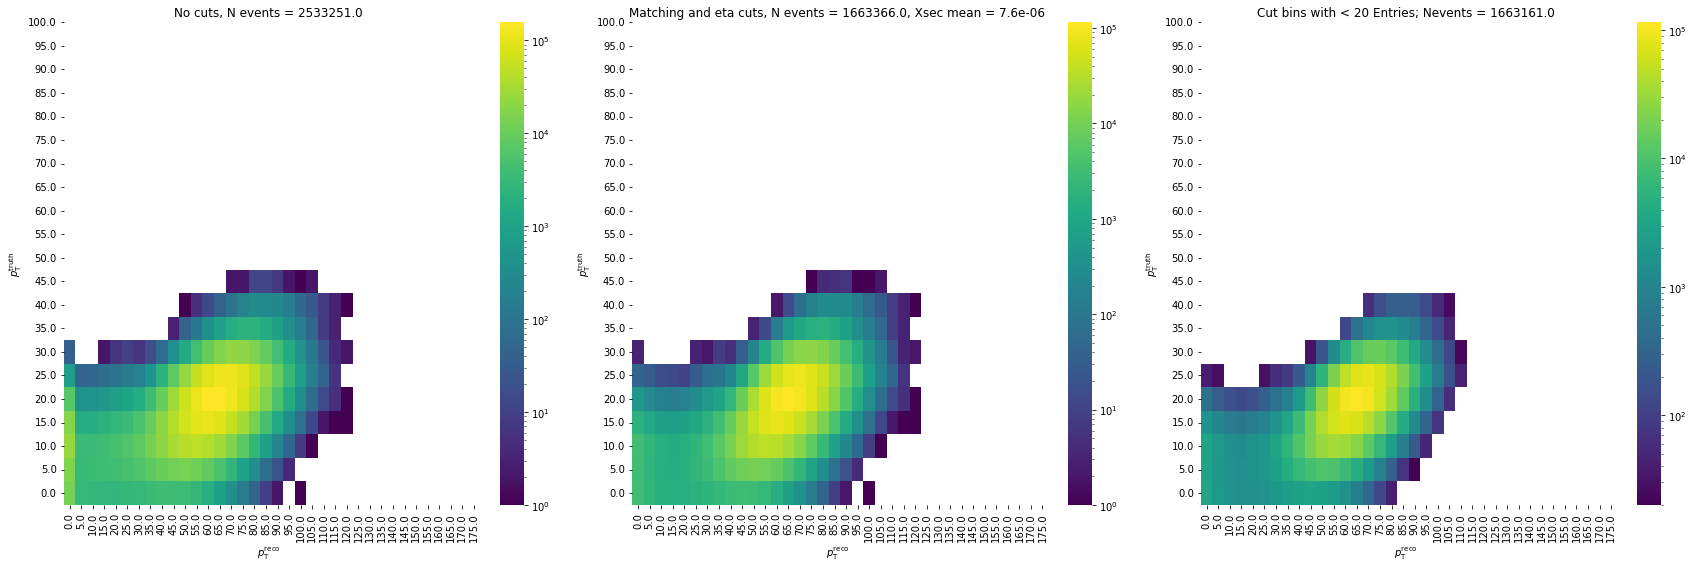

Matching and eta cuts, N events = 2328554.0, Xsec mean = 1.7e-09


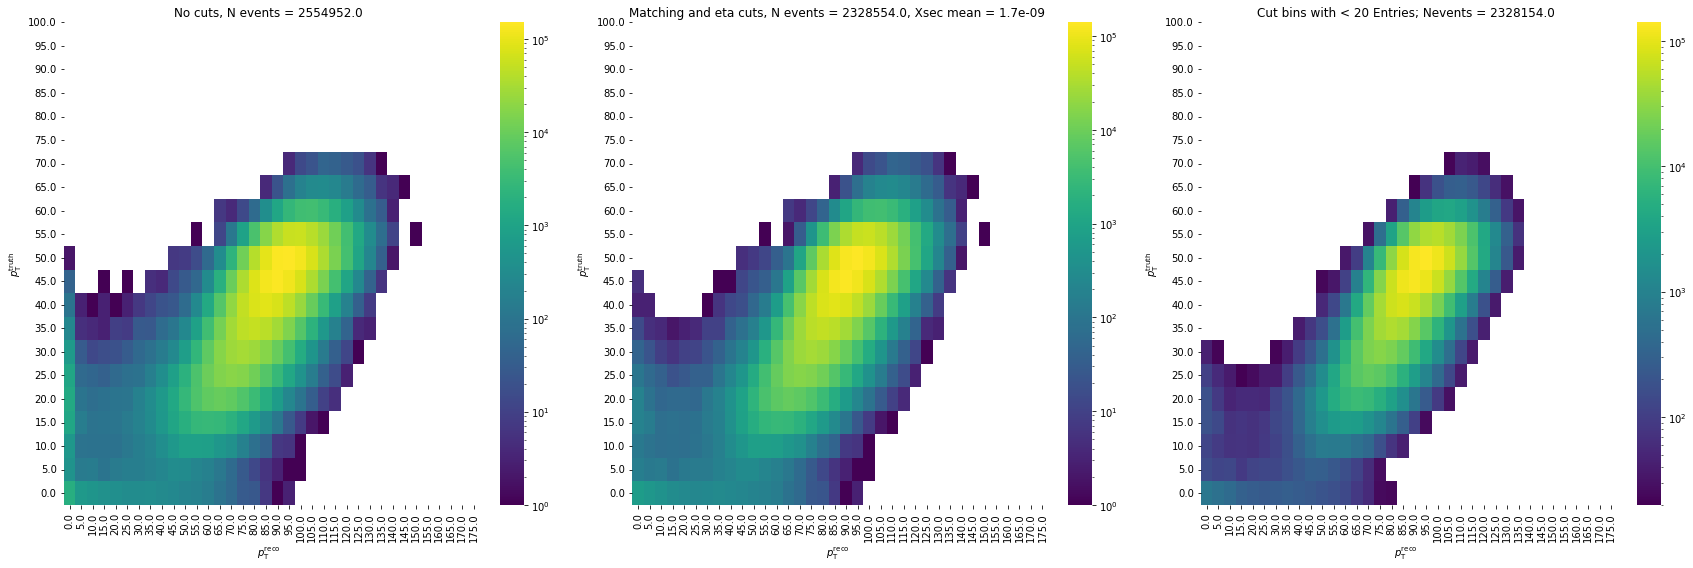

Matching and eta cuts, N events = 1273721.0, Xsec mean = 0.00065


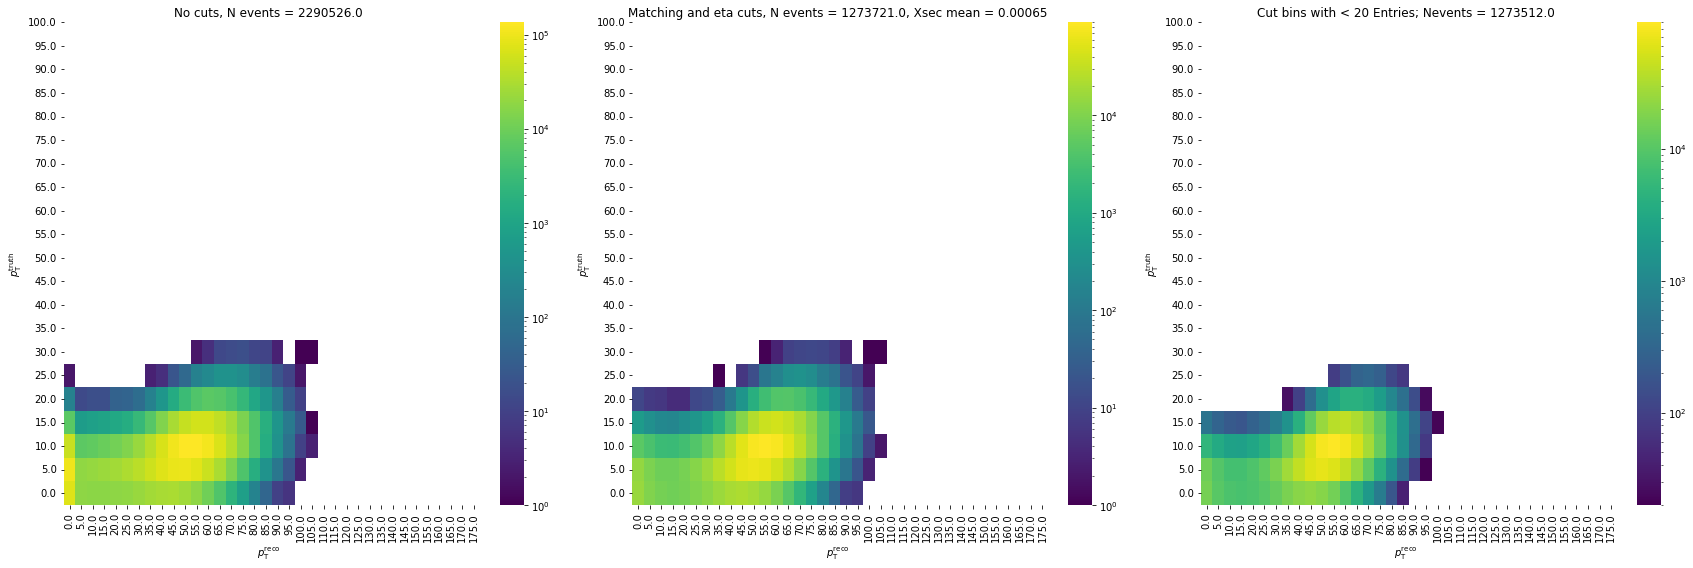

Matching and eta cuts, N events = 910926.0, Xsec mean = 0.077


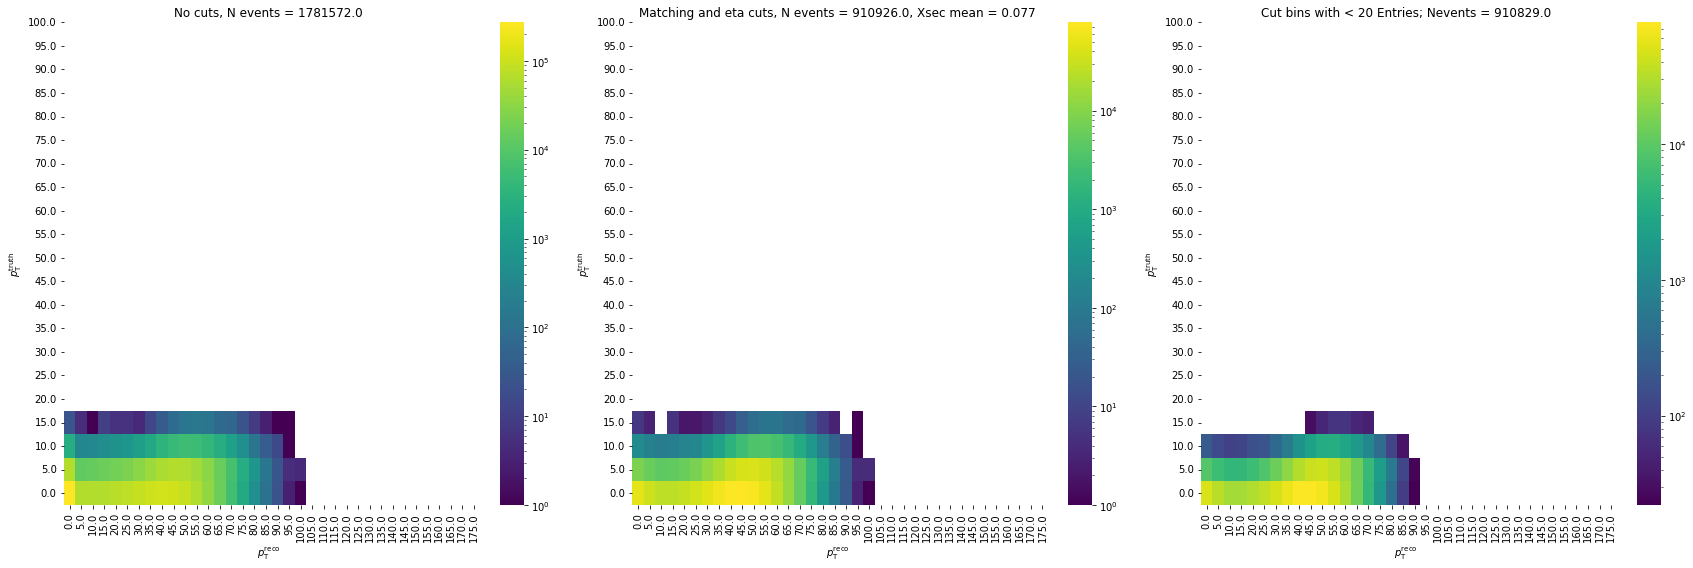

Matching and eta cuts, N events = 1111316.0, Xsec mean = 0.005


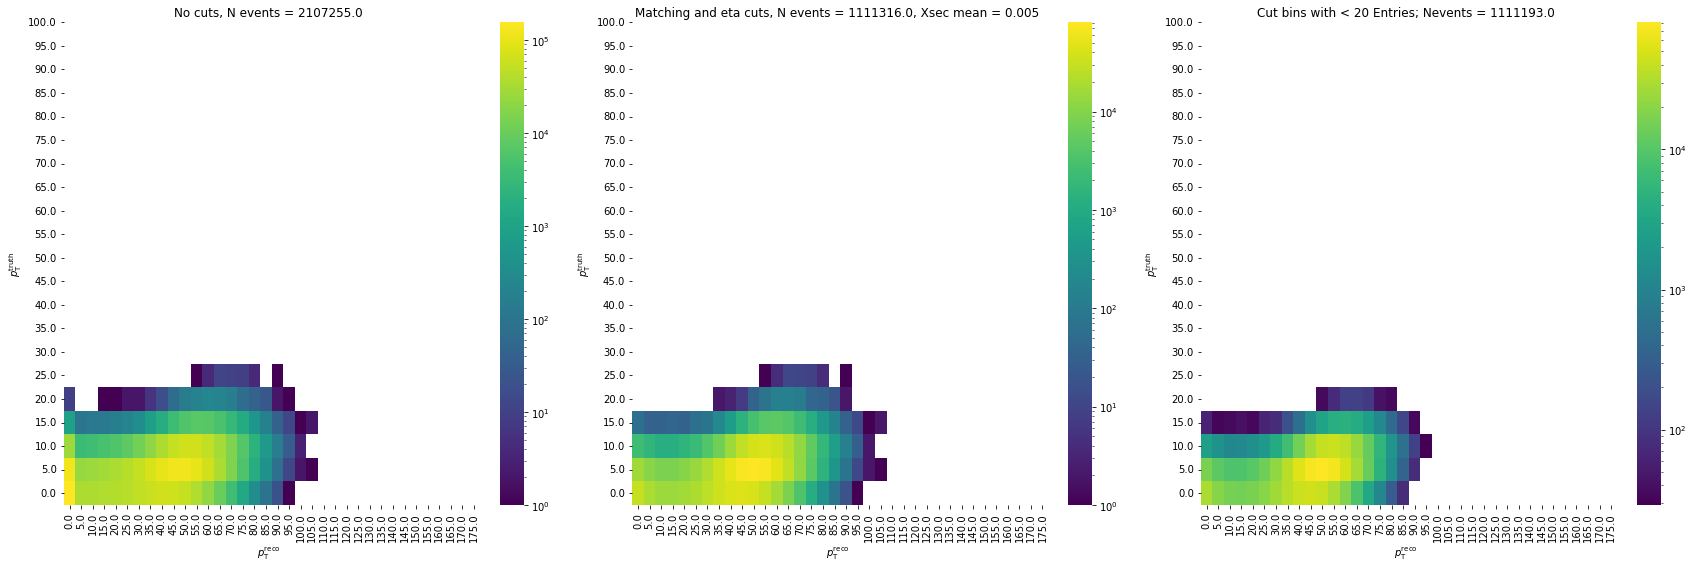

Matching and eta cuts, N events = 2140742.0, Xsec mean = 1.9e-08


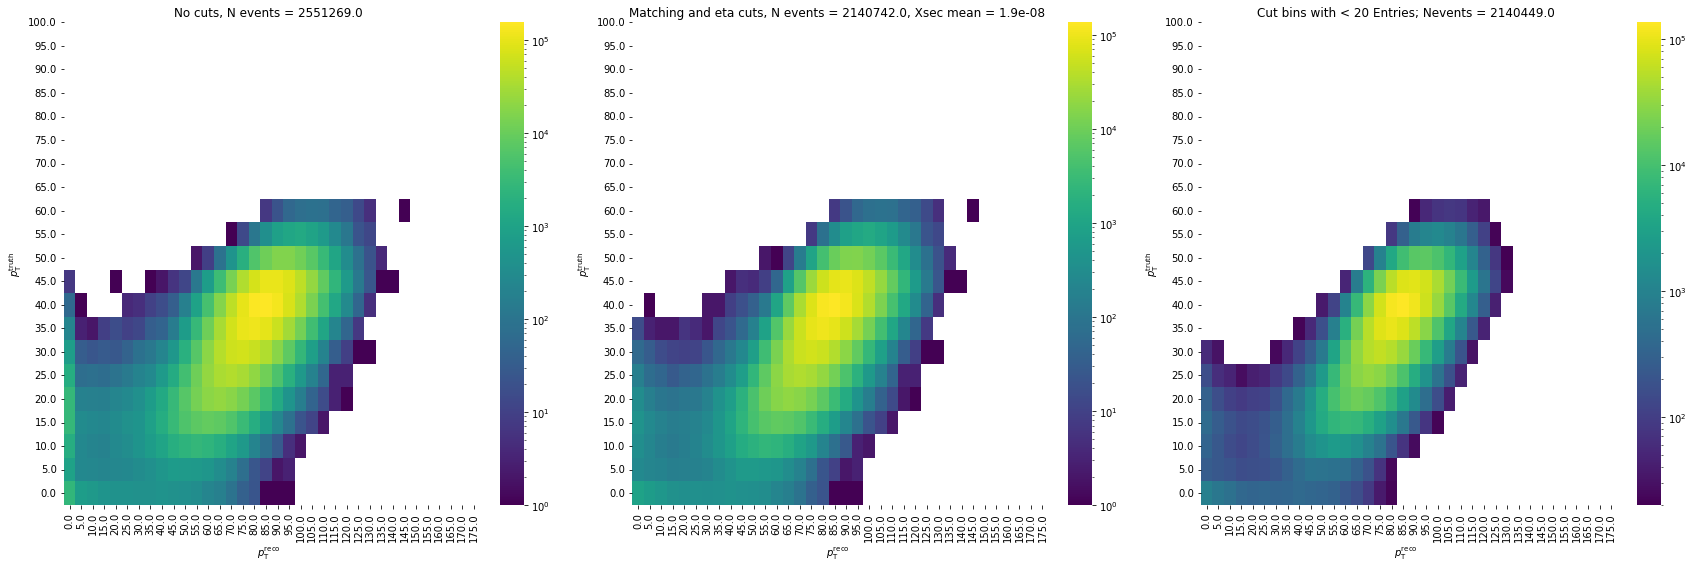

Matching and eta cuts, N events = 1551675.0, Xsec mean = 2.9e-05


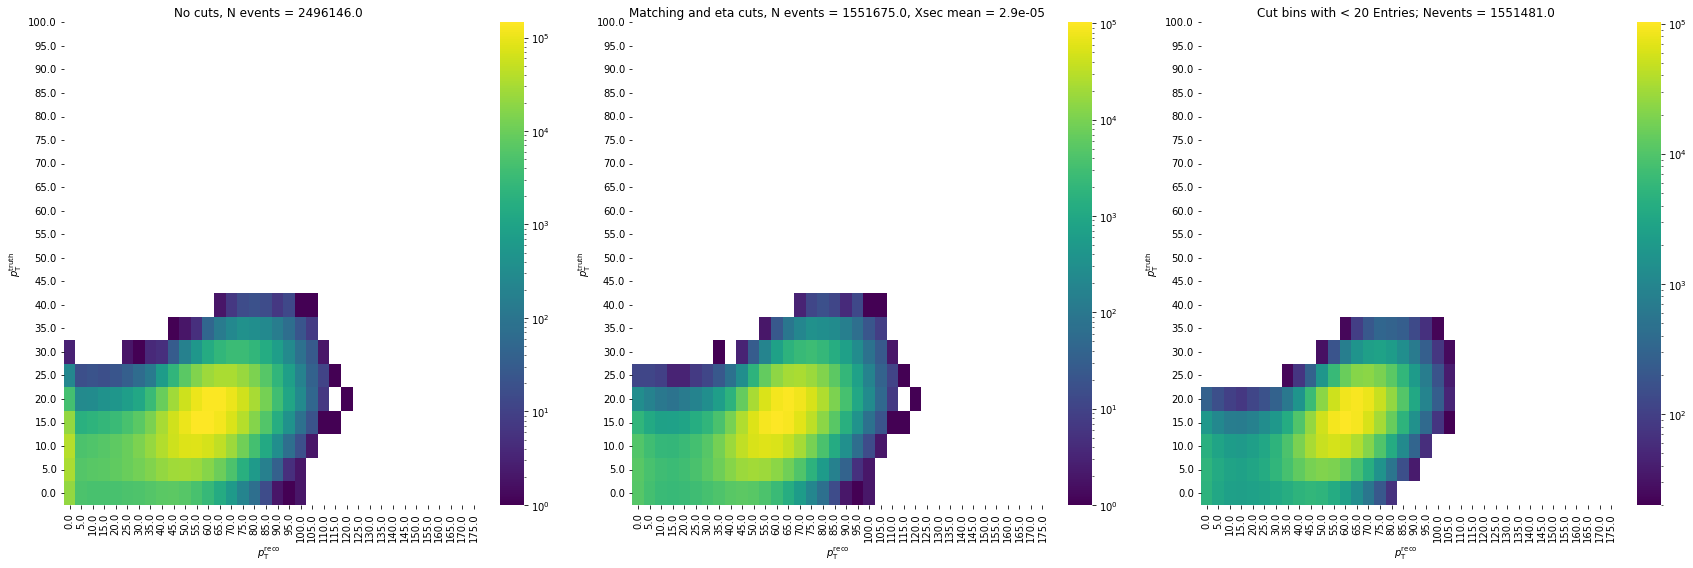

Matching and eta cuts, N events = 1963875.0, Xsec mean = 2e-07


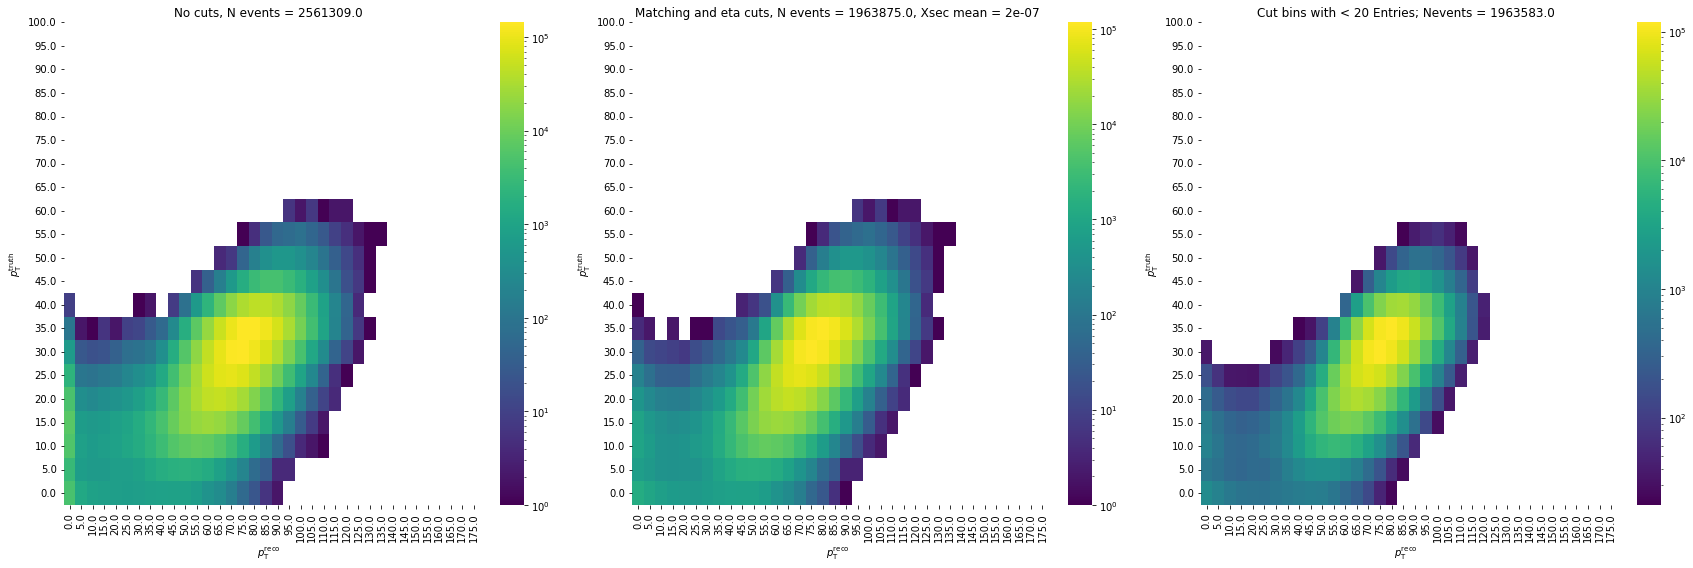

Matching and eta cuts, N events = 2413311.0, Xsec mean = 4.7e-10


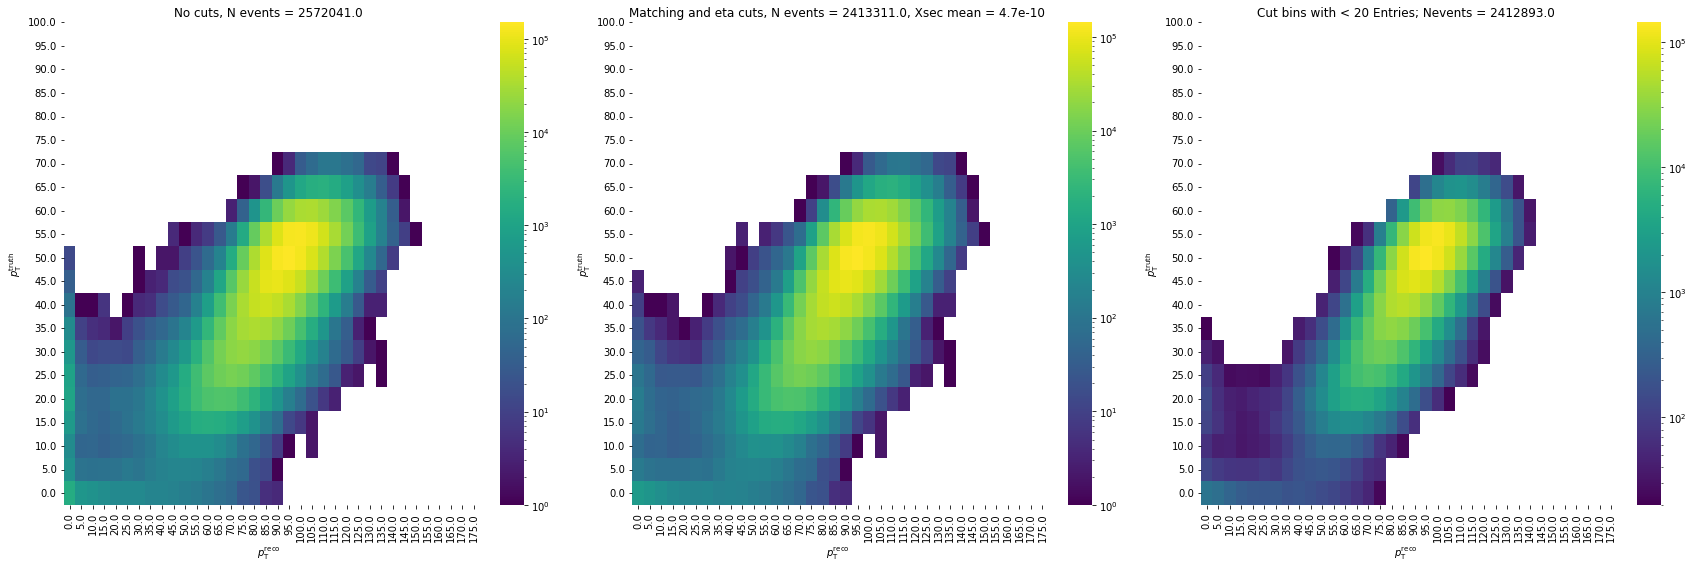

Matching and eta cuts, N events = 2054211.0, Xsec mean = 6.1e-08


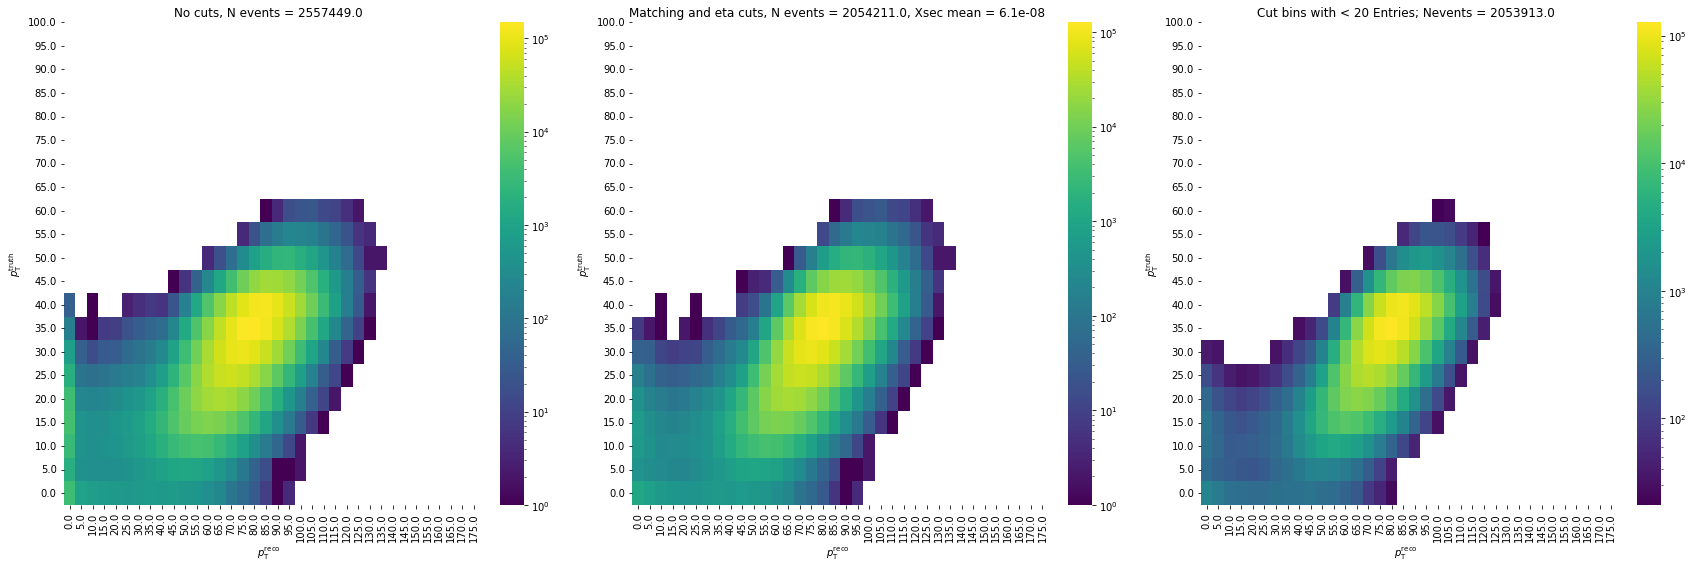

Matching and eta cuts, N events = 1412696.0, Xsec mean = 0.00012


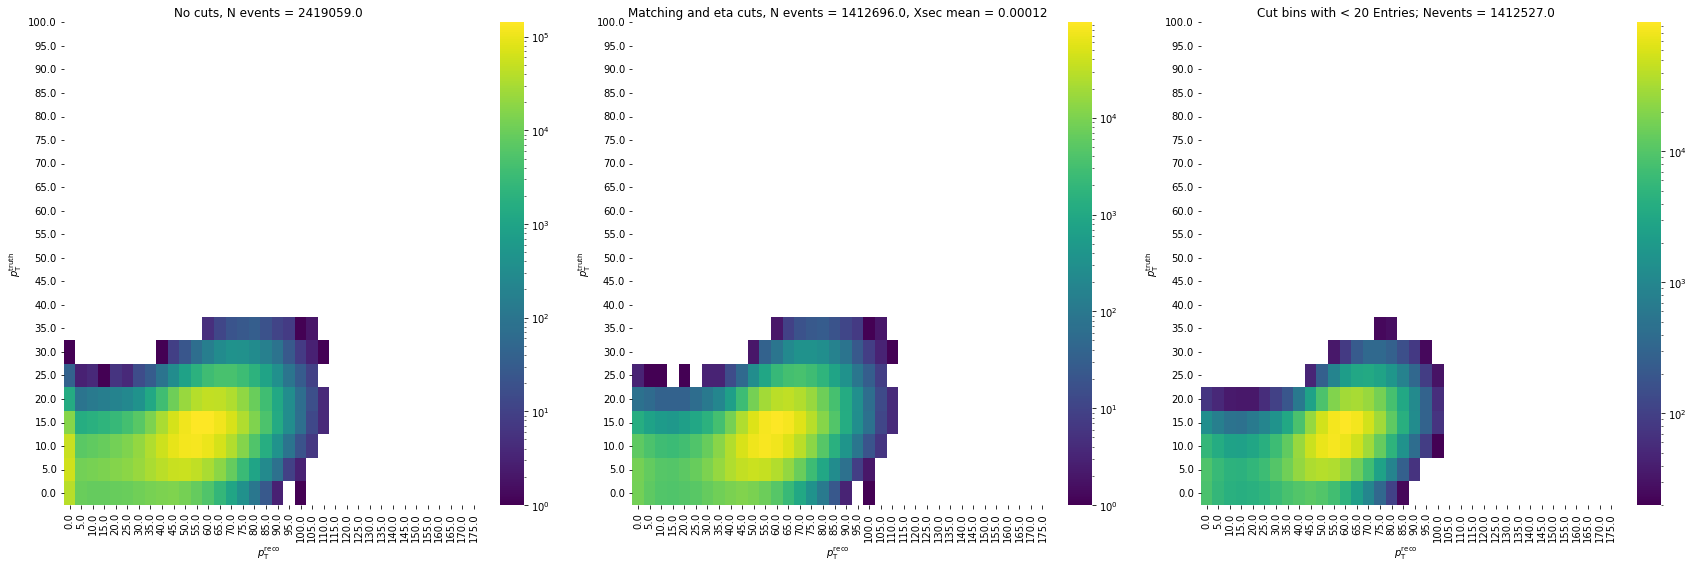

Matching and eta cuts, N events = 2507538.0, Xsec mean = 1.3e-10


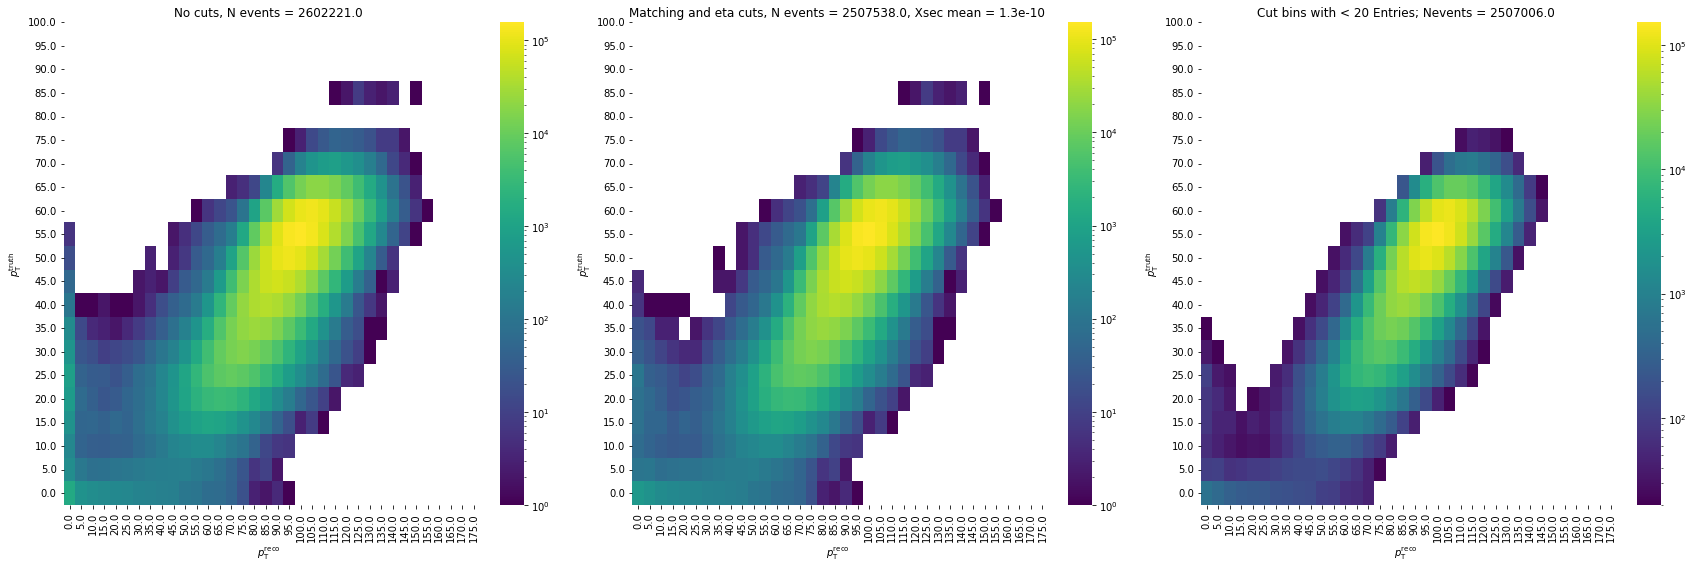

Matching and eta cuts, N events = 2595233.0, Xsec mean = 3.2e-11


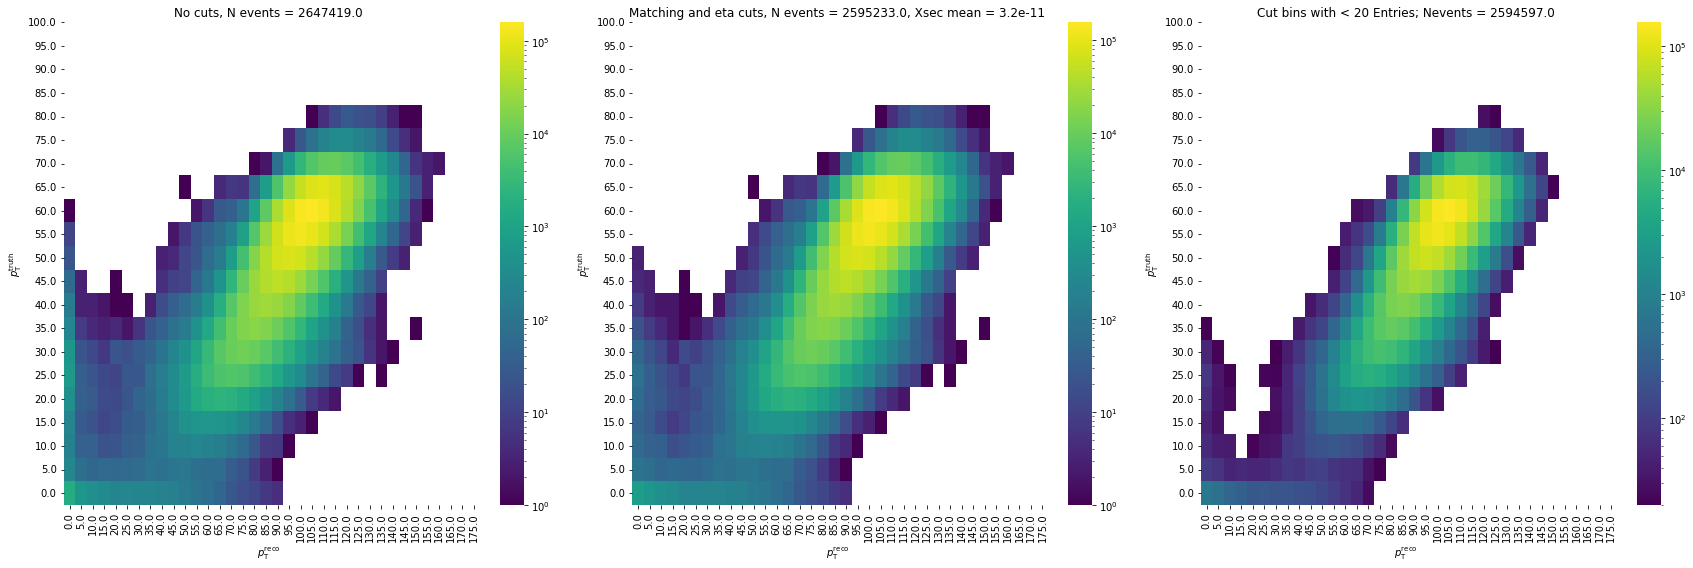

In [4]:
''' This notebook plots the old distributions of Xsec_groups/*.parquet files, applies the cuts,
bins them again, applies 20 min histogram bin cut, and then saves the resulting histograms to Xsec_groups/df_clean_Xsec_*.parquet'''

def outlier_clean_and_plot(in_file):
    # Plot the 2D histogram as a heatmap with logarithmic color scale
    df = pd.read_parquet(in_file)
    y_column = 'truth_pt'  # Replace with the actual column name
    x_column = 'reco_pt'  # Replace with the actual column name
    x_bins = np.linspace(0,175,36)  # Number of bins for the x-axis
    y_bins = np.linspace(0,100,21)  #80  # Number of bins for the y-axis

    fig, axes = plt.subplots(1, 3, figsize=(24, 8))
    H0, xedges, yedges = np.histogram2d(df[x_column], df[y_column], bins=[x_bins, y_bins])

    sns.heatmap(H0.T, cmap='viridis', cbar=True, norm=LogNorm(),xticklabels=xedges,ax=axes[0], yticklabels=yedges)
    axes[0].set_xlabel(r'$p_\mathrm{T}^\mathrm{reco}$')
    axes[0].set_ylabel(r'$p_\mathrm{T}^\mathrm{truth}$')
    axes[0].set_title(f'No cuts, N events = {np.sum(H0)}')
    plt.gca().invert_yaxis()

    X_mean = df['Xsec'].mean()

    # Apply the cuts to df
    df = df[df.matched_TtoR & df.matched_IPtoT & (np.abs(df.truth_eta) < 0.6)].reset_index(drop=True)

    H1, xedges, yedges = np.histogram2d(df[x_column], df[y_column], bins=[x_bins, y_bins])
    sns.heatmap(H1.T, cmap='viridis', cbar=True, norm=LogNorm(),xticklabels=xedges,ax=axes[1], yticklabels=yedges)
    axes[1].set_xlabel(r'$p_\mathrm{T}^\mathrm{reco}$')
    axes[1].set_ylabel(r'$p_\mathrm{T}^\mathrm{truth}$')
    axes[1].set_title(f'Matching and eta cuts, N events = {np.sum(H1)}, Xsec mean = {X_mean:0.2g}')
    print(f'Matching and eta cuts, N events = {np.sum(H1)}, Xsec mean = {X_mean:0.2g}')
    plt.gca().invert_yaxis()


    # Define outlier thresholds
    lower_threshold = 20  # Minimum count to be considered not an outlier
    
    # Identify bins with outliers
    outlier_mask = (H1 < lower_threshold)
    
    # Filter the DataFrame based on the identified outliers
    x_bin_indices = np.digitize(df[x_column], xedges) - 1
    y_bin_indices = np.digitize(df[y_column], yedges) - 1
    valid_indices = (x_bin_indices >= 0) & (x_bin_indices < len(xedges) - 1) & (y_bin_indices >= 0) & (y_bin_indices < len(yedges) - 1)

    outlier_indices = np.zeros(len(df), dtype=bool)
    outlier_indices[valid_indices] = outlier_mask[x_bin_indices[valid_indices], y_bin_indices[valid_indices]]
    df = df[~outlier_indices].reset_index(drop=True)

    H2, xedges, yedges = np.histogram2d(df[x_column], df[y_column], bins=[x_bins, y_bins])
    sns.heatmap(H2.T, cmap='viridis', cbar=True, norm=LogNorm(),xticklabels=xedges,ax=axes[2], yticklabels=yedges)
    axes[2].set_xlabel(r'$p_\mathrm{T}^\mathrm{reco}$')
    axes[2].set_ylabel(r'$p_\mathrm{T}^\mathrm{truth}$')
    axes[2].set_title(f'Cut bins with < 20 Entries; Nevents = {np.sum(H2)}')

    for ax in axes:
        ax.invert_yaxis()
    # Define outlier thresholds
    # plt.gca().invert_yaxis()
    plt.tight_layout()

    # Save the cleaned DataFrame
    out_file = in_file.replace('.parquet', '_clean.parquet')
    df.to_parquet(out_file)
    plt.savefig(out_file.replace('.parquet', '.png'))
    plt.savefig(out_file.replace('.parquet', '.pdf'))
    plt.show()

    # plot the draw data
# outlier_clean_and_plot('Xsec_groups/df_Xsec_0.parquet')
for file in glob('Xsec_groups/df_Xsec_*.parquet'):
    if 'clean' in file:
        continue
    outlier_clean_and_plot(file)